# **Analisis Beban Listrik**

<hr>

In [70]:
# Data manipulation
import pandas as pd 
import numpy as np  

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from bitstring import BitArray

# Data Modelling with tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Input

# Optimization (Genetic Algorithm)
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# **1. Data preparation**

In [71]:
# Ambil data pada sheet pertama

df = pd.read_excel("Beban Lisrik.xlsx",sheet_name=0, header=4)

In [72]:
df.head()

,HARI,TANGGAL,BB M,jam,BB.S,jam.1,00:30:00,01:00:00,01:30:00,02:00:00,...,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80
0,Selasa,2019-01-01 00:00:00,3331.49,19:30,2504.25,16:00,2663.06,2611.8,2567.65,2517.15,...,NaN,NaN,NaN,HARI,NaN,NaN,NaN,NaN,NaN,NaN
1,Rabu,2019-01-02 00:00:00,3844.69,19:30,3479.81,13:30,2422.54,2383.43,2362.38,2313.94,...,NaN,NaN,NaN,MINGGU,NaN,NaN,NaN,NaN,NaN,NaN
2,Kamis,2019-01-03 00:00:00,3918.24,19:30,3504.22,13:30,2837.31,2787.26,2758.84,2716.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Jumat,2019-01-04 00:00:00,4125.63,19:00,3650.37,13:30,2892.9,2885.24,2848.24,2814.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sabtu,2019-01-05 00:00:00,4043.54,19:00,3498.64,11:30,3058.79,3019.71,2971.55,2942.15,...,Jam,Hari,Minggu,Tanggal,Jam,Hari,Terendah,Tanggal,Jam,Hari


In [73]:
# Drop kolom BB M, jam, BB.S, dan jam.1
df = df.drop(columns=["BB M", "jam", "BB.S", "jam.1"])

# Pilih data "HARI" sampai "24:00"
df = df.loc[:, :'24:00']
df.columns

# Menyamkan format waktu '24:00:00' -> '00:00:00'
df.rename(columns={'24:00': '00:00:00'}, inplace=True)

# Drrop nilai kosong
df.dropna(inplace=True)

In [74]:
df = df.set_index(["HARI", "TANGGAL"]).stack().drop(index=['HARI', 'TANGGAL']).reset_index()
df

,HARI,TANGGAL,level_2,0
0,Selasa,2019-01-01,00:30:00,2663.06
1,Selasa,2019-01-01,01:00:00,2611.8
2,Selasa,2019-01-01,01:30:00,2567.65
3,Selasa,2019-01-01,02:00:00,2517.15
4,Selasa,2019-01-01,02:30:00,2472.2
...,...,...,...,...
17515,Selasa,2019-12-31,22:00:00,3241.47
17516,Selasa,2019-12-31,22:30:00,3148.79
17517,Selasa,2019-12-31,23:00:00,3055.43
17518,Selasa,2019-12-31,23:30:00,2986.36


In [75]:
# Perbaikan nama kolom 

df.rename(columns={"level_2": "WAKTU", 0:"BL"}, inplace=True)
df['WAKTU'] = pd.to_datetime(df['WAKTU'],format= '%H:%M:%S' ).dt.time

In [76]:
df['BL'] = df['BL'].astype('float64')

# **2. Data Exploration**

**1. Data beban listrik tahun 2019 (per 30 menit)**

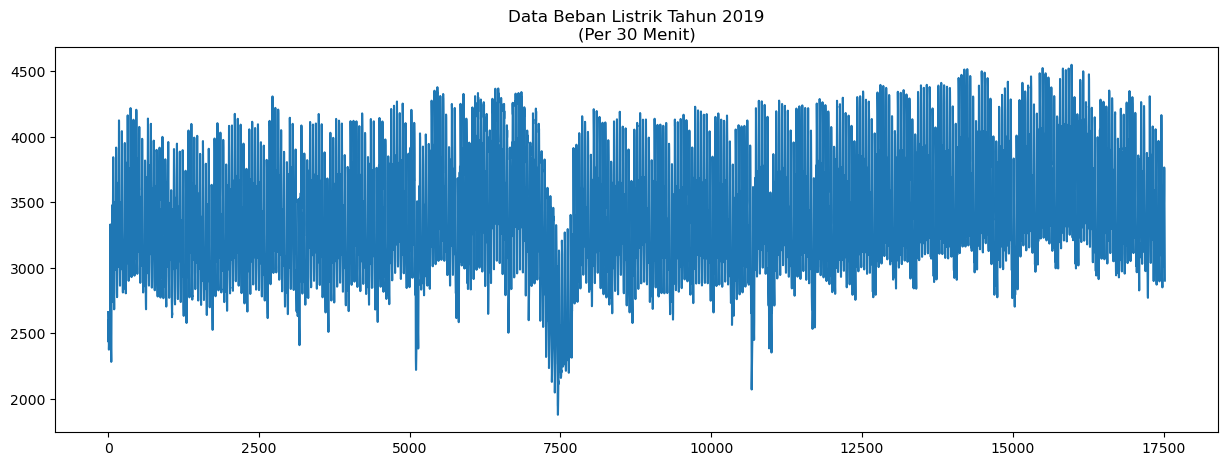

In [77]:
# plt.figure(figsize=(15, 5))
# plot = sns.lineplot(df['BL'])
# plot.set_title("Data Beban Listrik Tahun 2019\n(Per 30 Menit)")
# plt.show()

plt.figure(figsize=(15, 5))
plt.plot(df['BL'])
plt.title("Data Beban Listrik Tahun 2019\n(Per 30 Menit)")
plt.show()

**2. Rata-rata beban listrik setiap hari tahun 2019**

In [78]:
bl_per_hari = df.groupby('TANGGAL')['BL'].mean()

In [79]:
bl_per_hari[['2019-04-01']].index

DatetimeIndex(['2019-04-01'], dtype='datetime64[ns]', name='TANGGAL', freq=None)

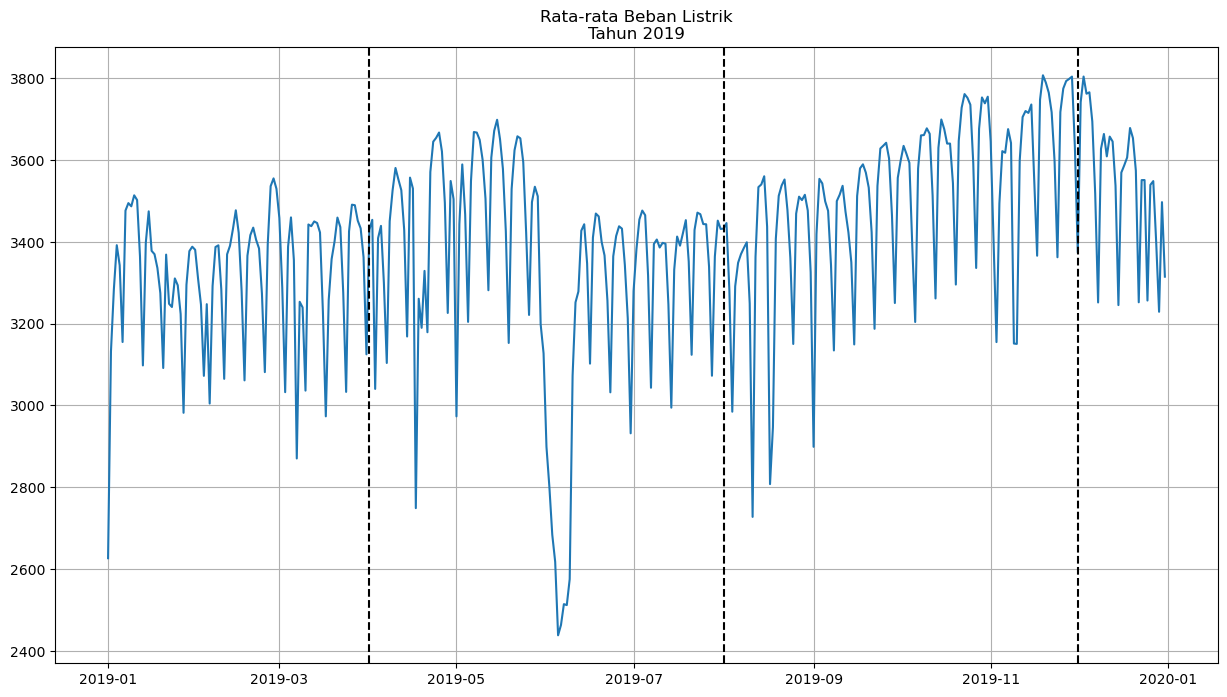

In [80]:
bl_per_hari = df.groupby('TANGGAL')['BL'].mean()

# plt.figure(figsize=(15, 8))
# plot = sns.lineplot(bl_per_hari)
# plot.set_title("Rata-rata Beban Listrik\nTahun 2019")

# plot.axvline(x=bl_per_hari[['2019-04-01']].index, ls="--", color='black')
# plot.axvline(x=bl_per_hari[['2019-08-01']].index, ls="--", color='black')
# plot.axvline(x=bl_per_hari[['2019-12-01']].index, ls="--", color='black')

# plt.grid()
# plt.show()

plt.figure(figsize=(15, 8))
plt.plot(bl_per_hari)
plt.title("Rata-rata Beban Listrik\nTahun 2019")

plt.axvline(x=bl_per_hari[['2019-04-01']].index, ls="--", color='black')
plt.axvline(x=bl_per_hari[['2019-08-01']].index, ls="--", color='black')
plt.axvline(x=bl_per_hari[['2019-12-01']].index, ls="--", color='black')

plt.grid()
plt.show()

**3. Rata-rata beban listrik berdasarkan waktunya**

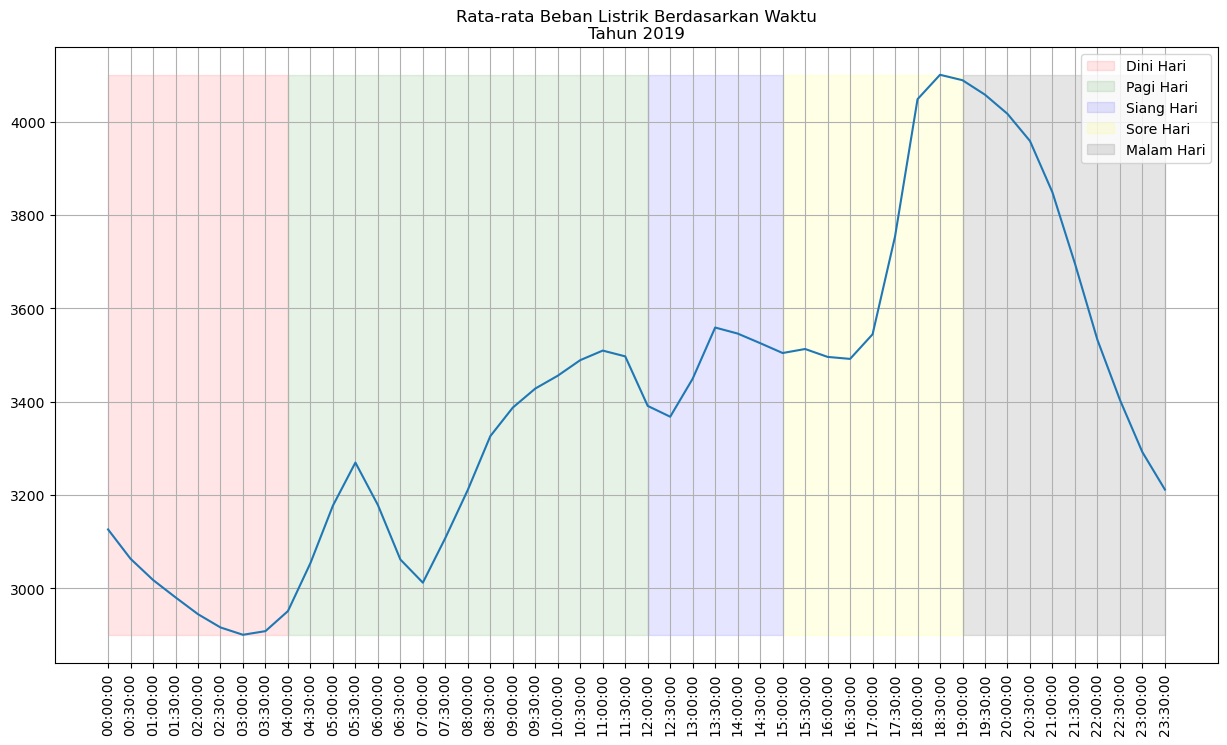

In [81]:
bl_per_waktu = df.groupby('WAKTU')['BL'].mean()
x_ticks = np.array(bl_per_waktu.index.astype(str))

plt.figure(figsize=(15, 8))
# plot = sns.lineplot(y=bl_per_waktu, x=x_ticks)
# plot.set_title("Rata-rata Beban Listrik Berdasarkan Waktu\nTahun 2019")
# plot.set_xticklabels(x_ticks, rotation='vertical')
plt.plot(x_ticks, bl_per_waktu)
plt.title("Rata-rata Beban Listrik Berdasarkan Waktu\nTahun 2019")
plt.xticks(x_ticks, rotation='vertical')

plt.grid()
plt.fill_between(x=x_ticks[:9], y1=bl_per_waktu.min(), y2=bl_per_waktu.max(), color='red', alpha=0.1, label="Dini Hari")
plt.fill_between(x=x_ticks[8:25], y1=bl_per_waktu.min(), y2=bl_per_waktu.max(), color='green', alpha=0.1, label="Pagi Hari")
plt.fill_between(x=x_ticks[24:31], y1=bl_per_waktu.min(), y2=bl_per_waktu.max(), color='blue', alpha=0.1, label="Siang Hari")
plt.fill_between(x=x_ticks[30:39], y1=bl_per_waktu.min(), y2=bl_per_waktu.max(), color='yellow', alpha=0.1, label="Sore Hari")
plt.fill_between(x=x_ticks[38:], y1=bl_per_waktu.min(), y2=bl_per_waktu.max(), color='black', alpha=0.1, label="Malam Hari")

# plt.axvline(x='00:00:00', ls="--", label="Dini Hari")
# plt.axvline(x='04:00:00', ls="--", label="Pagi Hari")
# plt.axvline(x='12:00:00', ls="--", label="Siang Hari")
# plt.axvline(x='14:00:00', ls="--", label="Sore Hari")
plt.legend()
plt.show()

**3. Rata-rata beban listrik berdasarkan Harinya**

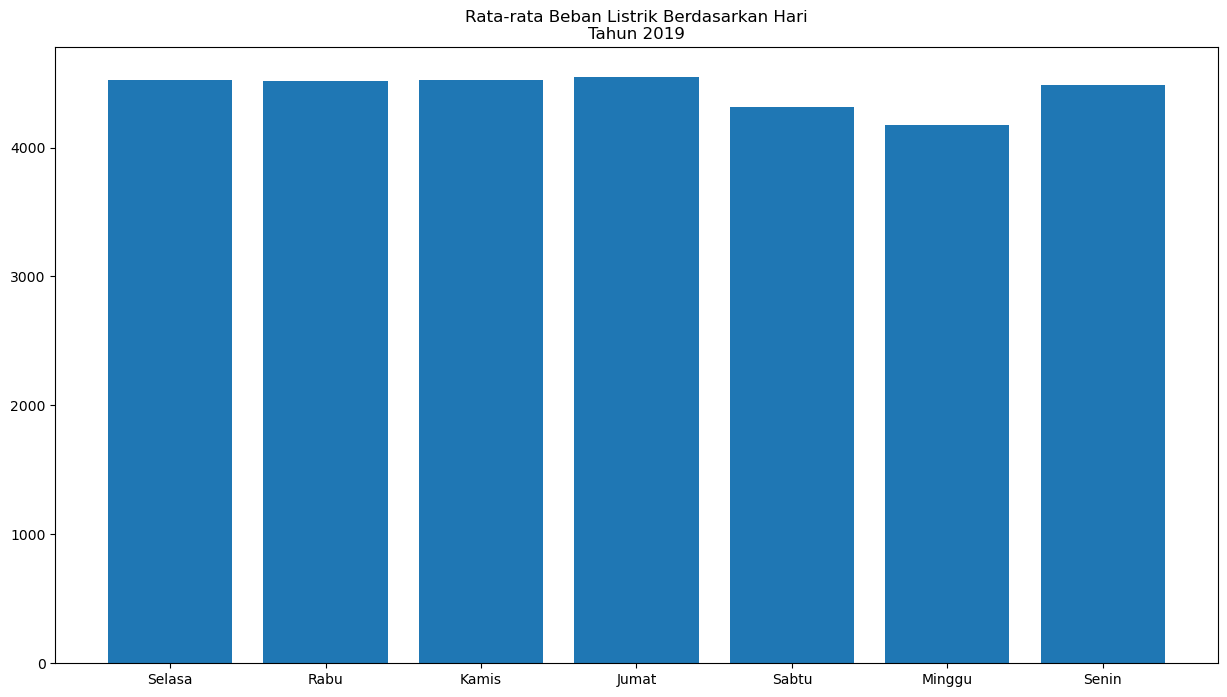

In [82]:
# plt.figure(figsize=(15, 8))
# plot = sns.barplot(data=df, x='HARI', y='BL', order=['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu'])
# plot.set_title("Rata-rata Beban Listrik Berdasarkan Hari\nTahun 2019")
# plt.show()

plt.figure(figsize=(15, 8))
plt.bar(data=df, x='HARI', height='BL')
plt.title("Rata-rata Beban Listrik Berdasarkan Hari\nTahun 2019")
plt.show()

In [83]:
df

,HARI,TANGGAL,WAKTU,BL
0,Selasa,2019-01-01,00:30:00,2663.06
1,Selasa,2019-01-01,01:00:00,2611.80
2,Selasa,2019-01-01,01:30:00,2567.65
3,Selasa,2019-01-01,02:00:00,2517.15
4,Selasa,2019-01-01,02:30:00,2472.20
...,...,...,...,...
17515,Selasa,2019-12-31,22:00:00,3241.47
17516,Selasa,2019-12-31,22:30:00,3148.79
17517,Selasa,2019-12-31,23:00:00,3055.43
17518,Selasa,2019-12-31,23:30:00,2986.36


**4. Plot ACF PACF**

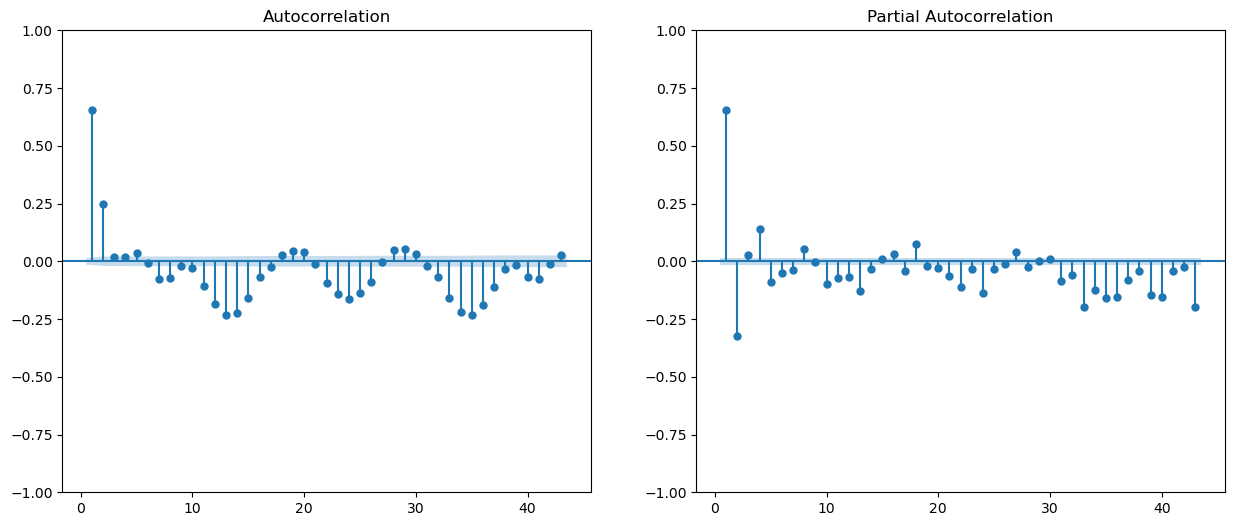

In [84]:
import statsmodels.api as sm

plt.figure(figsize=(15, 6))

sm.graphics.tsa.plot_acf(df['BL'].diff(1).dropna(), zero=False, ax=plt.subplot(121))
sm.graphics.tsa.plot_pacf(df['BL'].diff(1).dropna(), zero=False, ax=plt.subplot(122))
plt.show()

# **3. Data Preprocessing & Model building**

Base Model for RNN and LSTM <br>
reference: [Predicting Energy Consumption using RNN and LTSM by DARAGH MCCARTHY in Kaggle](https://www.kaggle.com/code/daraghmccarthy/predicting-energy-consumption-using-rnn-and-ltsm)

Spesification
1. Total Hidden layer = 3
1. Total Neuron (each layer) = 40
1. Activation (each layer) = tanh
1. return sequence = True (first layer and second layer) & return_sequence = False (third layer)
1. optimizer = adam

In [85]:
# Setting parameter sequence length
# Blok ini berisi setting parameter `sequence length` ini untuk seluruh model.

sequence_length= 12
list_model = []

In [86]:
data = df.set_index('TANGGAL')['BL']

In [87]:
# Splitting Data

train_val, test = train_test_split(data, test_size=0.3, shuffle=False)
train, val = train_test_split(train_val, test_size=0.3, shuffle=False)

## List Function

Function list:
- Timeseries Function: TimeseriesGenerator()
- Genetic Algorithm Optimization: GeneticAlgorithm()
- Training Procces: train_evaluate()
- Build model LSTM and RNN: create_model()
- Model Evaluation: model_eval()

Function Documentation:

1. TimeseriesGenerator(): Berfungsi untuk mentransformasi data agar siap diolah pada analisis Time series
    - dataset: Dataset yang ingin ditransformasi
    - length_input: Panjang data masukan (berfungsi sebagai fitur)
    - stride: selisih dataset
    - sampling_rate: jumlah data dalam fitur (1 berarti semuanya dipakai)
1. GeneticAlgorithm(): Berfungsi untuk melakukan optimisasi menggunakan algoritmma genetika
    - gene_length: Banyak gen
    - evaluate_function: Fungsi evaluasi
    - population_size: Banyak populasi
    - mate: Metode crossover (default menggunakan metode order)
    - mutate: Metode untuk mutasi (default menggunakan shuffle index)
    - select: Metode seleksi (default menggunakan roulette)
1. train_evaluate(): Berfungsi untuk melakukan training
    - model: model tensorflow yang dipakai
    - X_train: fitur data training
    - y_train: target data training
    - X_val: fitur data validation
    - y_val: target data validation
    - epoch: banyaknya iteras (training) default 10
    - batch_size: banyaknya batch size
    - optimizer: metode optimasi yang digunakan (default adam)
    - loss: fungsi loos
    - metric: ,etrik akurasi
1. create_model(): Berfungsi untuk membuat model
    - name: nama model
    - input_shape: ukuran data masukan
    - layer: model yang digunakan (hanya berfungsi untuk RNN dan LSTM)
    - base (True/False): Jika base=True maka menggunakan 'Base Model'. Jika base=False, maka menggunakan model customize dan parameter layer_parameter harus diisi layer_parameter=[unit, activation, return_sequence, dropout]
    - layer_parameter: Parameter hidden layer yang ingin ditambahkan dalam model, [unit, activation, return_sequence, dropout]
1. model_eval(): Berfungsi untuk mengevaluasi model
    - y_true: data sebenarnya
    - y_pred: data prediksi
1. model_forecast(): Berfungsi untuk melakukan forecasting
    - data: Data masukan
    - n_forecast: Periode forecasting
    - model: model yang digunakan


In [148]:
# Fungsi TimeseriesGenerator
def TimeseriesGenerator(dataset, length_input, stride=1, sampling_rate=1):
    
    dataX = []
    dataY = []
    
    for i in range(0, len(dataset) - length_input - 1, stride):
        X = dataset[i:(i+length_input):sampling_rate]
        y = dataset[(i+length_input)]
        dataX.append(X)
        dataY.append(y)
    
    return np.array(dataX), np.array(dataY)


# Genetic Algorithm
def GeneticAlgorithm(gene_length, 
                     evaluate_function, 
                     population_size, 
                     num_generations,
                     mate=tools.cxOrdered, 
                     mutate=tools.mutShuffleIndexes, 
                     select=tools.selRoulette, 
                     verbose=False):
    
    #Implementation of Genetic Algorithm using DEAP python library.

    creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
    creator.create('Individual', list, fitness = creator.FitnessMax)

    #initialize the variables as bernoilli random variables
    toolbox = base.Toolbox()
    toolbox.register('gene', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.gene, n = gene_length)
    toolbox.register('population', tools.initRepeat, list , toolbox.individual)

    #Ordered cross-over used for mating
    toolbox.register('mate', tools.cxOrdered)
    #Shuffle mutation to reorder the chromosomes
    toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
    #use roulette wheel selection algorithm
    toolbox.register('select', tools.selRoulette)
    #training function used for evaluating fitness of individual solution.
    toolbox.register('evaluate', evaluate_function)

    population = toolbox.population(n = population_size)
    
    ea = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = verbose)


# Train and evaluation model
def train_evaluate(model, X_train, y_train, X_val, y_val, epoch=10, batch_size=128, optimizer='adam', loss='mse', metric='mse', verbose=1):
    
    # Compiling
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metric)
    
    # Fitting Process
    model.fit(X_train,
              y_train,
              validation_data = (X_val, y_val),
              epochs = epoch, 
              batch_size=batch_size,
              verbose=verbose)
    
    return model


# Create Model function 
def create_model(name, input_shape, layer, base=True, neurons=[]):
    """_summary_

    Args:
        name (string): Model's name
        input_shape (int): Input Shape
        model (object): Tensorflow model (RNN/LSTM)
        base (bool, optional): Base Model. Defaults to True.
        *layers_parameter: If using customize model [unit, activation, return_sequence, dropout]

    Returns:
        _type_: _description_
    """
    
    model = Sequential(name=name)

    model.add(Input(shape= input_shape)) # Input layer
    
    if base:
        model.add(layer(units=40, activation='tanh', return_sequences=True, dropout=0.15, name='first_layer')) # First Hidden layer
        model.add(layer(units=40, activation='tanh', return_sequences=True, dropout=0.15, name='second_layer')) # Second Hidden layer
    else:
        for i, neuron in enumerate(neurons):
            model.add(layer(units=neuron, activation='tanh', return_sequences=True, dropout=0.13, name=f'{i}_layer'))
    
    model.add(layer(units=40, activation='tanh', return_sequences=False, dropout=0.15, name='last_layer'))
    model.add(Dense(units=1, name='output')) # Output layer

    return model


# Evaluation function
def model_eval(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_pred = np.std(y_pred)

    # dict_score = {'Score':['MSE', 'RMSE', 'MAE', 'MAPE', 'std_pred'],
    #             'Value':[mse, rmse, mae, mape, std_pred]}

    # return pd.DataFrame(dict_score)
    return [mse, rmse, mae, mape, std_pred] 


# Forecasting
def model_forecast(model, data, n_forecast):
    
    forecast_list = []
    
    sequence_length = model.get_config()['layers'][0]['config']['batch_input_shape'][1]
    
    scaller = MinMaxScaler().fit(data.reshape(-1,1))
    
    for i in range(n_forecast):
        data_input = data[len(data)-1:len(data)-1-sequence_length:-1]
        data_input = scaller.transform(data_input.reshape(-1,1))
        data_input = data_input.reshape(1, -1, 1)
        
        forecast = model.predict(data_input, verbose=0)
        
        forecast_list = np.append(forecast_list, forecast)
        data = np.append(data, forecast_list)
        
        # print(data[len(data)-1])
    
    forecast_list = scaller.inverse_transform(forecast_list.reshape(-1,1))
    
    return forecast_list

# Save model pickle

import pickle

# def save(name, model):
#     filename = f'{name}.pkl'
#     with open(filename, 'wb') as txt:
#         pickle.dump(model, txt)

def save(name, model):
    filename = f'{name}.h5'
    model.save(filename)


## 3A. Model: Reccurent Neural Network (RNN) - Base Model

##### ***Data Preprocessing: Pre Training***

In [89]:
# Scalling using MinMax Scaller Method

scaller = MinMaxScaler()
scaller.fit(train.values.reshape(-1,1))

train_scal = scaller.transform(train.values.reshape(-1,1))
val_scal = scaller.transform(val.values.reshape(-1,1))

In [90]:
# Generate data into Timse series using Time-Series Generator

train_feature, train_target = TimeseriesGenerator(dataset=train_scal, length_input=sequence_length)
val_feature, val_target = TimeseriesGenerator(dataset=val_scal, length_input=sequence_length)

##### ***Model building: Simple RNN***

In [91]:
# Create RNN with base architecture models

model_rnn = create_model(name='Model_RNN_base', input_shape=(train_feature.shape[1],1), layer=SimpleRNN, base=True)

model_rnn.summary()

Model: "Model_RNN_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (SimpleRNN)     (None, 12, 40)            1680      
                                                                 
 second_layer (SimpleRNN)    (None, 12, 40)            3240      
                                                                 
 last_layer (SimpleRNN)      (None, 40)                3240      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 8201 (32.04 KB)
Trainable params: 8201 (32.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### ***Training evaluation***

In [92]:
# Training Process

training_rnn = train_evaluate(model_rnn, train_feature, train_target, val_feature, val_target, epoch=50)

Epoch 1/50
67/67 [==============================] - 5s 18ms/step - loss: 0.1668 - mse: 0.1668 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 2/50
67/67 [==============================] - 1s 10ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 3/50
67/67 [==============================] - 1s 11ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 4/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 5/50
67/67 [==============================] - 1s 10ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6/50
67/67 [==============================] - 1s 11ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 7/50
67/67 [==============================] - 1s 9ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 8/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0150 - mse

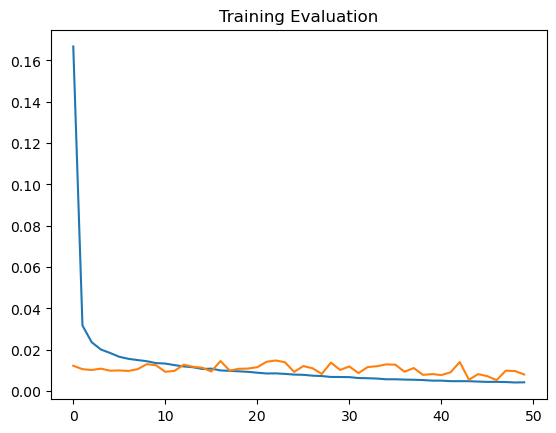

In [93]:
# Training Process Plot

train_mse = training_rnn.history.history['mse']
val_mse = training_rnn.history.history['val_mse']

plt.plot(train_mse)
plt.plot(val_mse)
plt.title("Training Evaluation")

plt.show()

In [94]:
list_model.append(model_rnn)

## 3B. Model: Long Short Term Memory (LSTM) - Base Model

##### ***Data Preprocessing: Pre Training***

In [95]:
# Scalling using MinMax Scaller Method

scaller = MinMaxScaler()
scaller.fit(train.values.reshape(-1,1))

train_scal = scaller.transform(train.values.reshape(-1,1))
val_scal = scaller.transform(val.values.reshape(-1,1))

In [96]:
# Generate data into Timse series using Time-Series Generator

train_feature, train_target = TimeseriesGenerator(dataset=train_scal, length_input=sequence_length)
val_feature, val_target = TimeseriesGenerator(dataset=val_scal, length_input=sequence_length)

##### ***Model building: LSTM***

In [97]:
# Create LSTM with base architecture

model_lstm = create_model(name='Model_LSTM_base', input_shape=(train_feature.shape[1],1), layer=LSTM, base=True)

model_lstm.summary()

Model: "Model_LSTM_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (LSTM)          (None, 12, 40)            6720      
                                                                 
 second_layer (LSTM)         (None, 12, 40)            12960     
                                                                 
 last_layer (LSTM)           (None, 40)                12960     
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 32681 (127.66 KB)
Trainable params: 32681 (127.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### ***Training evaluation***

In [98]:
# Training Process
training_lstm = train_evaluate(model_lstm, train_feature, train_target, val_feature, val_target, epoch=50)

Epoch 1/50
67/67 [==============================] - 10s 49ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 2/50
67/67 [==============================] - 2s 30ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 3/50
67/67 [==============================] - 2s 31ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 4/50
67/67 [==============================] - 2s 28ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 5/50
67/67 [==============================] - 2s 29ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 6/50
67/67 [==============================] - 2s 29ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 7/50
67/67 [==============================] - 2s 29ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 8/50
67/67 [==============================] - 2s 24ms/step - loss: 0.0140 - 

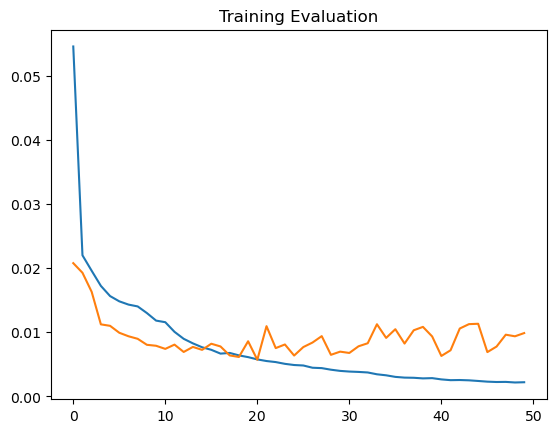

In [99]:
train_mse = training_lstm.history.history['mse']
val_mse = training_lstm.history.history['val_mse']

plt.plot(train_mse)
plt.plot(val_mse)
plt.title("Training Evaluation")

plt.show()

In [100]:
list_model.append(model_lstm)

## 3C. Model: Custom Model

### Model 1

In [101]:
# # Setting parameter
# # Setting parameter pada blok ini. 
# # Jika ingin model yang berbeda tinggal ganti parameter yang ada disini lalu jalankan semua kode dalam section `model 1` ini 

# # Model yang digunakan (LSTM/SimpleRNN)
# model = LSTM 

# # Banyak neuron
# neuron_1 = 10 # Banyak neuron pada layer 1
# neuron_2 = 10 # Banyak neuron pada layer 2

# # Epoch
# epoch = 50 # Epoch

# # Input Sequence
# sequence_length = 12

In [102]:
# # Scalling using MinMax Scaller Method

# scaller = MinMaxScaler()
# scaller.fit(train.values.reshape(-1,1))

# train_scal = scaller.transform(train.values.reshape(-1,1))
# val_scal = scaller.transform(val.values.reshape(-1,1))

# # Generate data into Timse series using Time-Series Generator

# train_feature, train_target = TimeseriesGenerator(dataset=train_scal, length_input=sequence_length)
# val_feature, val_target = TimeseriesGenerator(dataset=val_scal, length_input=sequence_length)

##### ***Model building: Custom Model***

In [103]:
# # Create LSTM with base architecture
# model_custom = create_model(name=f'Model_Custom_{model.__name__}_{neuron_1}_{sequence_length}', input_shape=(train_feature.shape[1],1), layer=model, base=False, neurons=[neuron_1, neuron_2])

# model_custom.summary()

In [104]:
# # Training Process
# training_custom = train_evaluate(model_custom, train_feature, train_target, val_feature, val_target, epoch=epoch)

In [105]:
# train_mse = training_custom.history.history['mse']
# val_mse = training_custom.history.history['val_mse']

# plt.plot(train_mse)
# plt.plot(val_mse)
# plt.title("Training Evaluation")

# plt.show()

In [106]:
# list_model.append(model_custom)

### Model 2 

In [107]:
# # Setting parameter
# # Setting parameter pada blok ini. 
# # Jika ingin model yang berbeda tinggal ganti parameter yang ada disini lalu jalankan semua kode dalam section `model 1` ini 

# # Model yang digunakan (LSTM/SimpleRNN)
# model = LSTM

# # Banyak neuron
# neuron_1 = 20 # Banyak neuron pada layer 1
# neuron_2 = 20 # Banyak neuron pada layer 2

# # Epoch
# epoch = 50 # Epoch

# # Input Sequence
# sequence_length = 8

In [108]:
# # Scalling using MinMax Scaller Method

# scaller = MinMaxScaler()
# scaller.fit(train.values.reshape(-1,1))

# train_scal = scaller.transform(train.values.reshape(-1,1))
# val_scal = scaller.transform(val.values.reshape(-1,1))

# # Generate data into Timse series using Time-Series Generator

# train_feature, train_target = TimeseriesGenerator(dataset=train_scal, length_input=sequence_length)
# val_feature, val_target = TimeseriesGenerator(dataset=val_scal, length_input=sequence_length)

In [109]:
# # Create LSTM with base architecture
# model_custom = create_model(name=f'Model_Custom_{model.__name__}_{neuron_1}_{sequence_length}', input_shape=(train_feature.shape[1],1), layer=model, base=False, neurons=[neuron_1, neuron_2])

# model_custom.summary()

In [110]:
# # Training Process
# training_custom = train_evaluate(model_custom, train_feature, train_target, val_feature, val_target, epoch=epoch)

In [111]:
# train_mse = training_custom.history.history['mse']
# val_mse = training_custom.history.history['val_mse']

# plt.plot(train_mse)
# plt.plot(val_mse)
# plt.title("Training Evaluation")

# plt.show()

In [112]:
# list_model.append(model_custom)

### Model 3

In [113]:
# # Setting parameter
# # Setting parameter pada blok ini. 
# # Jika ingin model yang berbeda tinggal ganti parameter yang ada disini lalu jalankan semua kode dalam section `model 1` ini 

# # Model yang digunakan (LSTM/SimpleRNN)
# model = LSTM

# # Banyak neuron
# neuron_1 = 30 # Banyak neuron pada layer 1
# neuron_2 = 30 # Banyak neuron pada layer 2

# # Epoch
# epoch = 50 # Epoch

# # Input Sequence
# sequence_length = 8

In [114]:
# # Scalling using MinMax Scaller Method

# scaller = MinMaxScaler()
# scaller.fit(train.values.reshape(-1,1))

# train_scal = scaller.transform(train.values.reshape(-1,1))
# val_scal = scaller.transform(val.values.reshape(-1,1))

# # Generate data into Timse series using Time-Series Generator

# train_feature, train_target = TimeseriesGenerator(dataset=train_scal, length_input=sequence_length)
# val_feature, val_target = TimeseriesGenerator(dataset=val_scal, length_input=sequence_length)

In [115]:
# # Create LSTM with base architecture
# model_custom = create_model(name=f'Model_Custom_{model.__name__}_{neuron_1}_{sequence_length}', input_shape=(train_feature.shape[1],1), layer=model, base=False, neurons=[neuron_1, neuron_2])

# model_custom.summary()

In [116]:
# # Training Process
# training_custom = train_evaluate(model_custom, train_feature, train_target, val_feature, val_target, epoch=epoch)

In [117]:
# train_mse = training_custom.history.history['mse']
# val_mse = training_custom.history.history['val_mse']

# plt.plot(train_mse)
# plt.plot(val_mse)
# plt.title("Training Evaluation")

# plt.show()

In [118]:
# list_model.append(model_custom)

### Model Generator

In [119]:
def train_custom_model(model, param):
    # Banyak neuron
    neuron_1 = param[0] # Banyak neuron pada layer 1
    neuron_2 = param[0] # Banyak neuron pada layer 2

    # Epoch
    epoch = 50 # Epoch

    # Input Sequence
    sequence_length = param[1]

    scaller = MinMaxScaler()
    scaller.fit(train.values.reshape(-1,1))

    train_scal = scaller.transform(train.values.reshape(-1,1))
    val_scal = scaller.transform(val.values.reshape(-1,1))

    # Generate data into Timse series using Time-Series Generator

    train_feature, train_target = TimeseriesGenerator(dataset=train_scal, length_input=sequence_length)
    val_feature, val_target = TimeseriesGenerator(dataset=val_scal, length_input=sequence_length)
    
    # Create LSTM with base architecture
    model_custom = create_model(name=f'Model_Custom_{model.__name__}_{neuron_1}_{sequence_length}', input_shape=(train_feature.shape[1],1), layer=model, base=False, neurons=[neuron_1, neuron_2])

    model_custom.summary()
    
    # Training Process
    training_custom = train_evaluate(model_custom, train_feature, train_target, val_feature, val_target, epoch=epoch, verbose=0)
    
    train_mse = training_custom.history.history['mse']
    val_mse = training_custom.history.history['val_mse']
    
    list_model.append(model_custom)

    plt.plot(train_mse)
    plt.plot(val_mse)
    plt.title(f"Training Evaluation\nModel_Custom_{model.__name__}_{neuron_1}_{sequence_length}")

    plt.show()

Model: "Model_Custom_LSTM_10_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_layer (LSTM)              (None, 12, 10)            480       
                                                                 
 1_layer (LSTM)              (None, 12, 10)            840       
                                                                 
 last_layer (LSTM)           (None, 40)                8160      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 9521 (37.19 KB)
Trainable params: 9521 (37.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


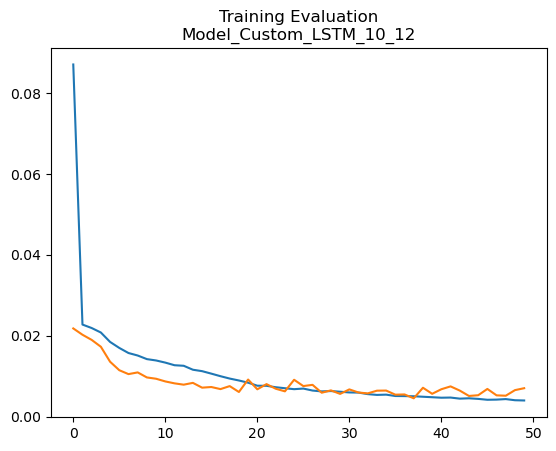

Model: "Model_Custom_LSTM_20_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_layer (LSTM)              (None, 12, 20)            1760      
                                                                 
 1_layer (LSTM)              (None, 12, 20)            3280      
                                                                 
 last_layer (LSTM)           (None, 40)                9760      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 14841 (57.97 KB)
Trainable params: 14841 (57.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


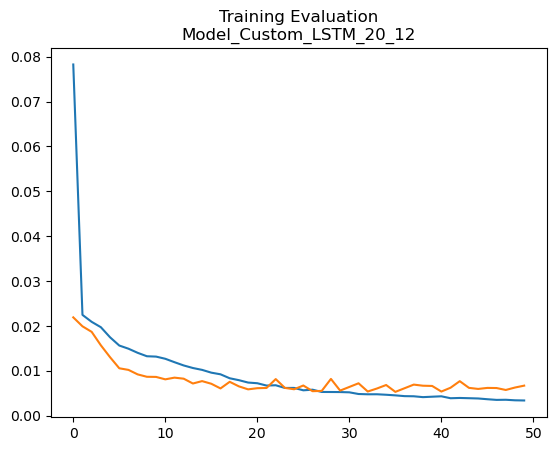

Model: "Model_Custom_LSTM_10_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_layer (LSTM)              (None, 8, 10)             480       
                                                                 
 1_layer (LSTM)              (None, 8, 10)             840       
                                                                 
 last_layer (LSTM)           (None, 40)                8160      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 9521 (37.19 KB)
Trainable params: 9521 (37.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


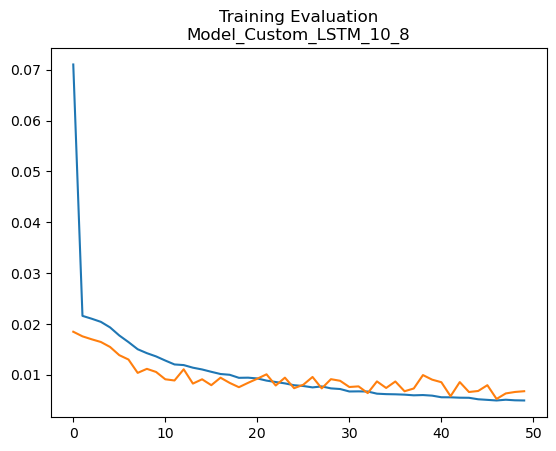

Model: "Model_Custom_LSTM_20_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_layer (LSTM)              (None, 8, 20)             1760      
                                                                 
 1_layer (LSTM)              (None, 8, 20)             3280      
                                                                 
 last_layer (LSTM)           (None, 40)                9760      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 14841 (57.97 KB)
Trainable params: 14841 (57.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


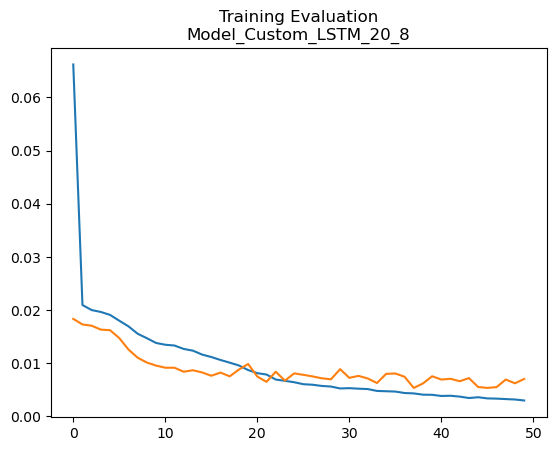

Model: "Model_Custom_SimpleRNN_10_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_layer (SimpleRNN)         (None, 12, 10)            120       
                                                                 
 1_layer (SimpleRNN)         (None, 12, 10)            210       
                                                                 
 last_layer (SimpleRNN)      (None, 40)                2040      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 2411 (9.42 KB)
Trainable params: 2411 (9.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


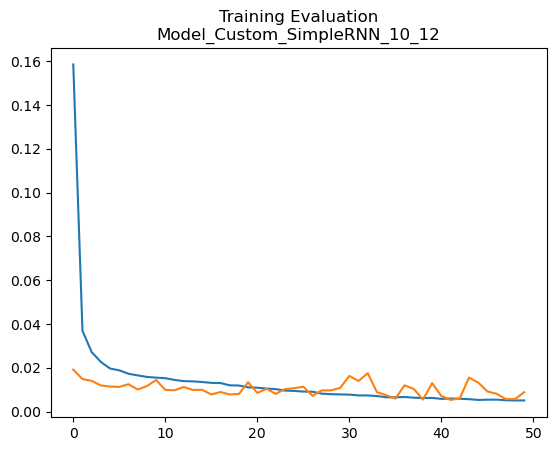

Model: "Model_Custom_SimpleRNN_20_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_layer (SimpleRNN)         (None, 12, 20)            440       
                                                                 
 1_layer (SimpleRNN)         (None, 12, 20)            820       
                                                                 
 last_layer (SimpleRNN)      (None, 40)                2440      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 3741 (14.61 KB)
Trainable params: 3741 (14.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


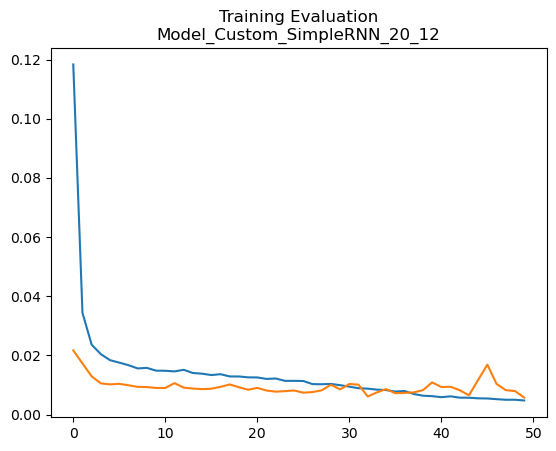

Model: "Model_Custom_SimpleRNN_10_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_layer (SimpleRNN)         (None, 8, 10)             120       
                                                                 
 1_layer (SimpleRNN)         (None, 8, 10)             210       
                                                                 
 last_layer (SimpleRNN)      (None, 40)                2040      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 2411 (9.42 KB)
Trainable params: 2411 (9.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


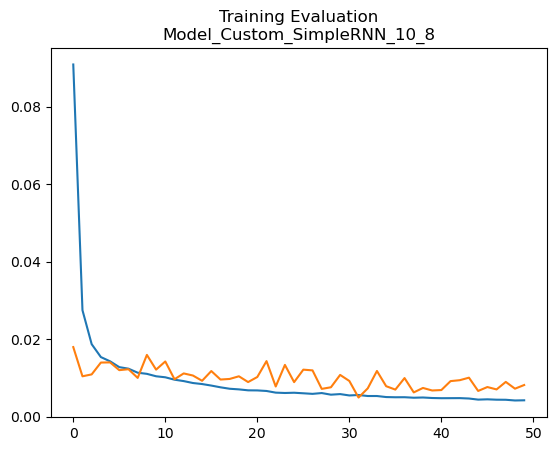

Model: "Model_Custom_SimpleRNN_20_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_layer (SimpleRNN)         (None, 8, 20)             440       
                                                                 
 1_layer (SimpleRNN)         (None, 8, 20)             820       
                                                                 
 last_layer (SimpleRNN)      (None, 40)                2440      
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 3741 (14.61 KB)
Trainable params: 3741 (14.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


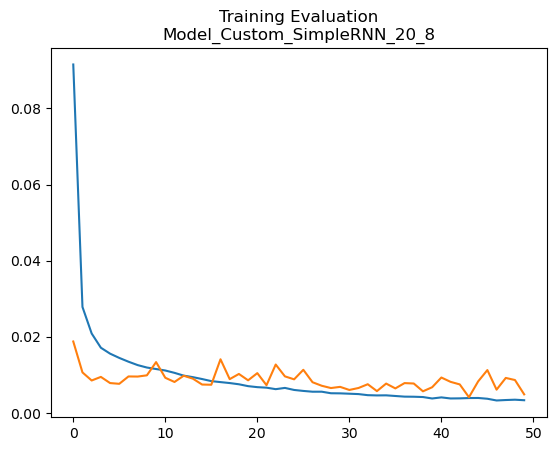

In [120]:
models = [LSTM, SimpleRNN]
params = [(10, 12), (20,12), (10,8), (20,8)]

for model in models:
    for param in params:
        train_custom_model(model, param)

# **4. Model Benchmarking**


Evaluation all models using data testing

**Model Evaluation**

c:\Users\bayud\miniconda3\envs\lstm-project\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\bayud\miniconda3\envs\lstm-project\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\bayud\miniconda3\envs\lstm-project\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\bayud\miniconda3

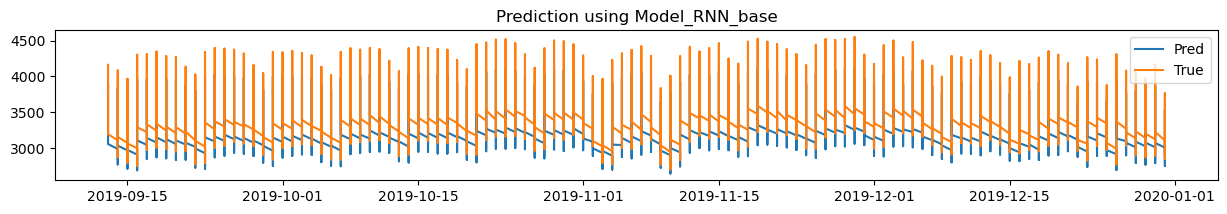

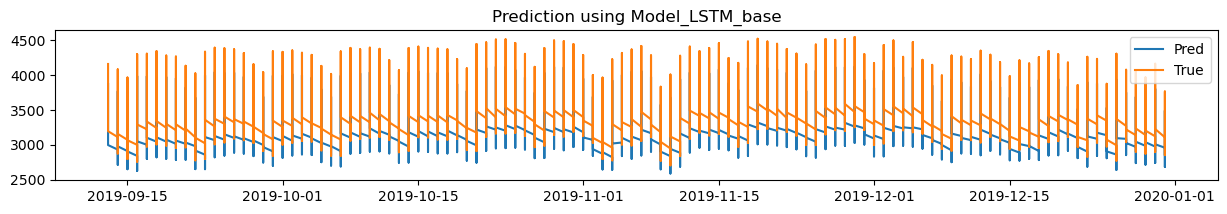

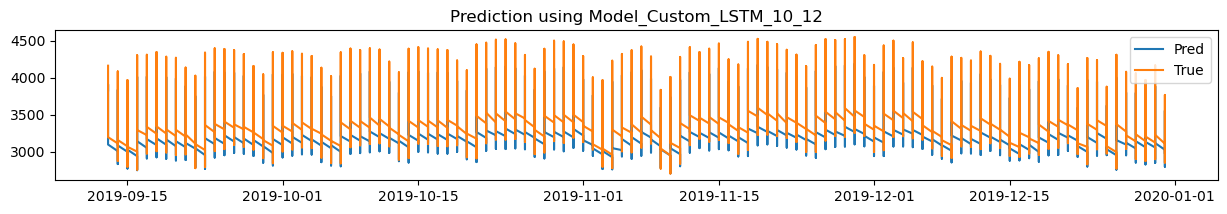

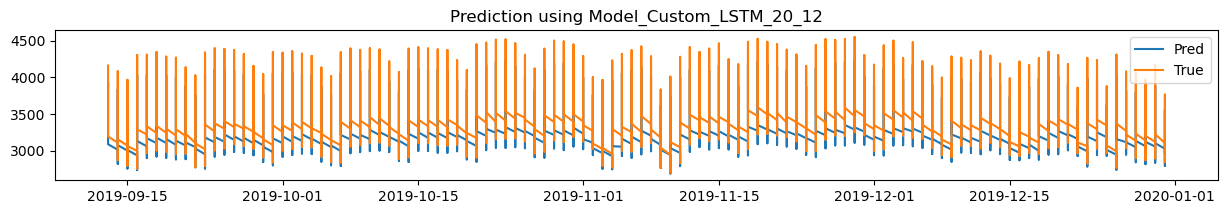

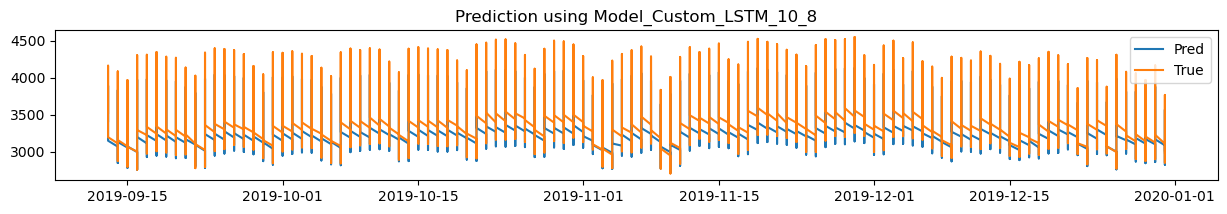

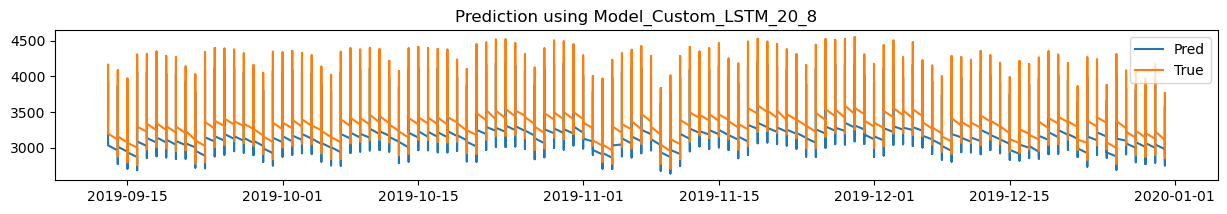

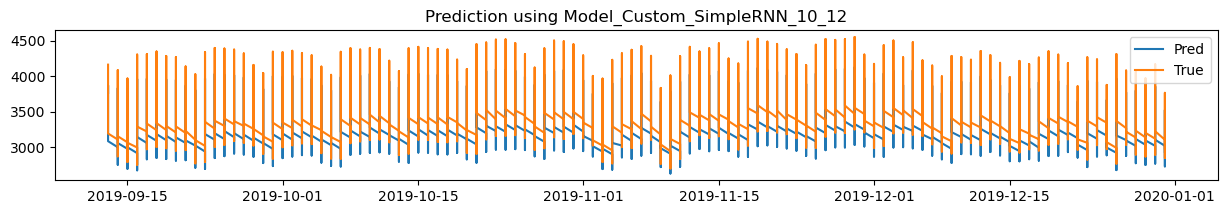

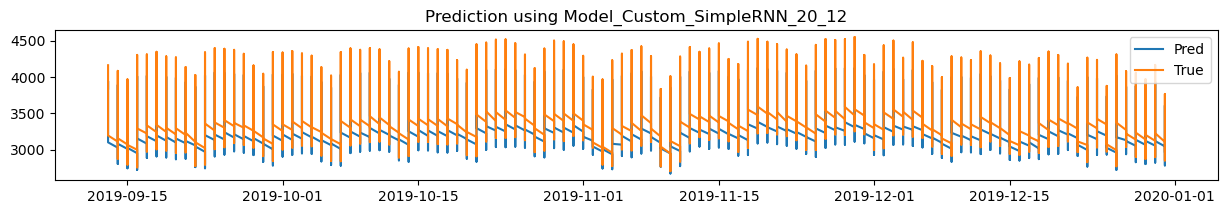

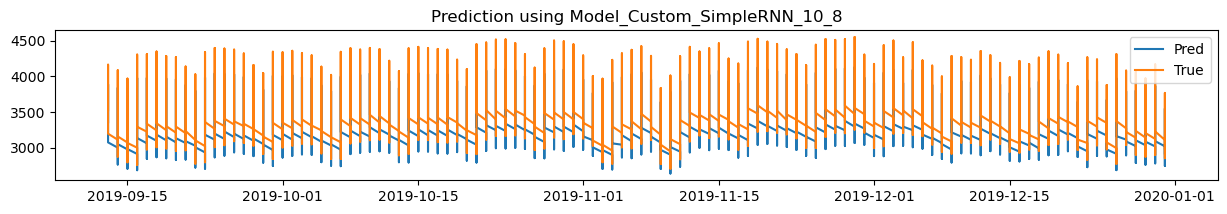

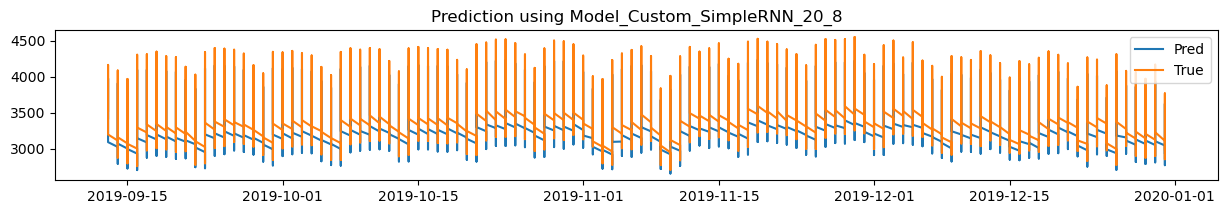

 
Error Calculation


,Model,MSE,RMSE,MAE,MAPE,STD_PRED
0,Model_RNN_base,71297.942246,267.016745,239.030917,0.065134,326.809021
1,Model_LSTM_base,78530.494863,280.232930,264.744780,0.073060,342.404999
2,Model_Custom_LSTM_10_12,63615.388329,252.220912,217.889625,0.058889,317.665253
3,Model_Custom_LSTM_20_12,57306.925227,239.388649,207.506553,0.056179,325.175842
4,Model_Custom_LSTM_10_8,57020.457964,238.789568,194.823612,0.052285,317.554474
5,Model_Custom_LSTM_20_8,57332.078905,239.441180,215.176123,0.059030,347.498932
6,Model_Custom_SimpleRNN_10_12,74783.484256,273.465691,241.319907,0.065938,335.595215
7,Model_Custom_SimpleRNN_20_12,48983.671346,221.322550,188.569214,0.051290,341.971436
8,Model_Custom_SimpleRNN_10_8,68446.327699,261.622491,231.457589,0.063246,337.721039
9,Model_Custom_SimpleRNN_20_8,39565.258139,198.910176,173.040178,0.047385,356.174316


In [121]:
# plt.figure(figsize=(15, 10))

evaluation = []
columns = ['Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'STD_PRED']

prediction = []

prediction_result = {}
prediction_eval = {}

for i, model in enumerate(list_model):
    
    sequence_length = model.get_config()['layers'][0]['config']['batch_input_shape'][1]
    
    # Preprocessing Data Testing
    test_scal = scaller.transform(test.values.reshape(-1,1)) # Scalling 
    test_feature, test_target = TimeseriesGenerator(dataset=test_scal, length_input=sequence_length)
    
    # Predict Testing data
    target_prediction = model.predict(test_feature, verbose=0)

    # Inverse Transform
    target_prediction_inv = scaller.inverse_transform(target_prediction.reshape(-1,1))
    test_target_inv = scaller.inverse_transform(test_target.reshape(-1,1))
    
    # Prediction
    prediction_eval[model.name] = target_prediction_inv
    
    # Make plot
    plt.figure(figsize=(15, 23))
    plt.subplot(len(list_model),1,0+1)
    plt.plot(test[(sequence_length+1):].index.values.reshape(-1,1), target_prediction_inv, label="Pred")
    plt.plot(test[(sequence_length+1):].index.values.reshape(-1,1), test_target_inv, label="True")
    plt.legend()
    plt.title(f"Prediction using {model.name}")

    score = model_eval(test_target_inv, target_prediction_inv)
    
    save(model.name, model)
    
    score.insert(0, model.name)
    evaluation.append(score)

plt.show()

print(" ")
print("Error Calculation")
df_result = pd.DataFrame(evaluation, columns=columns)
display(df_result)

In [122]:
df_result.sort_values(by="MAPE")

,Model,MSE,RMSE,MAE,MAPE,STD_PRED
9,Model_Custom_SimpleRNN_20_8,39565.258139,198.910176,173.040178,0.047385,356.174316
7,Model_Custom_SimpleRNN_20_12,48983.671346,221.322550,188.569214,0.051290,341.971436
4,Model_Custom_LSTM_10_8,57020.457964,238.789568,194.823612,0.052285,317.554474
3,Model_Custom_LSTM_20_12,57306.925227,239.388649,207.506553,0.056179,325.175842
2,Model_Custom_LSTM_10_12,63615.388329,252.220912,217.889625,0.058889,317.665253
5,Model_Custom_LSTM_20_8,57332.078905,239.441180,215.176123,0.059030,347.498932
8,Model_Custom_SimpleRNN_10_8,68446.327699,261.622491,231.457589,0.063246,337.721039
0,Model_RNN_base,71297.942246,267.016745,239.030917,0.065134,326.809021
6,Model_Custom_SimpleRNN_10_12,74783.484256,273.465691,241.319907,0.065938,335.595215
1,Model_LSTM_base,78530.494863,280.232930,264.744780,0.073060,342.404999


# **4. Model Prediction**

In [123]:
test.shape

(5256,)

**Model_Custom_SimpleRNN_20_8**

In [124]:
model = list_model[9] # Model_Custom_SimpleRNN_20_8

sequence_length = model.get_config()['layers'][0]['config']['batch_input_shape'][1]
    
# Preprocessing Data Testing
test_scal = scaller.transform(test.values.reshape(-1,1)) # Scalling 
test_feature, test_target = TimeseriesGenerator(dataset=test_scal, length_input=sequence_length)

# Predict Testing data
target_prediction = model.predict(test_feature, verbose=0)

# Inverse Transform
target_prediction_inv = scaller.inverse_transform(target_prediction.reshape(-1,1))
test_target_inv = scaller.inverse_transform(test_target.reshape(-1,1))

In [125]:
print("Model: ", model.name)

result1 = pd.DataFrame({
    "BL": test_target_inv.flatten(),
    "Prediction": target_prediction_inv.flatten()
})

result1['error'] = abs(result1.BL - result1.Prediction)

display(result1)

Model:  Model_Custom_SimpleRNN_20_8


,BL,Prediction,error
0,3525.14,3419.765869,105.374131
1,3553.03,3379.782227,173.247773
2,3769.88,3389.838623,380.041377
3,4142.19,3606.919678,535.270322
4,4162.13,3973.717285,188.412715
...,...,...,...
5242,3368.17,3321.727295,46.442705
5243,3241.47,3215.407471,26.062529
5244,3148.79,3106.593262,42.196738
5245,3055.43,3016.019043,39.410957


In [126]:
result1.to_excel('result1.xlsx')

**Model_Custom_LSTM_10_12**

In [127]:
model2 = list_model[2] # Model_Custom_LSTM_10_12

sequence_length = model2.get_config()['layers'][0]['config']['batch_input_shape'][1]
    
# Preprocessing Data Testing
test_scal = scaller.transform(test.values.reshape(-1,1)) # Scalling 
test_feature, test_target = TimeseriesGenerator(dataset=test_scal, length_input=sequence_length)

# Predict Testing data
target_prediction = model2.predict(test_feature, verbose=0)

# Inverse Transform
target_prediction_inv = scaller.inverse_transform(target_prediction.reshape(-1,1))
test_target_inv = scaller.inverse_transform(test_target.reshape(-1,1))

In [128]:
print("Model: ", model.name)

result2 = pd.DataFrame({
    "BL": test_target_inv.flatten(),
    "Prediction": target_prediction_inv.flatten()
})

result2['error'] = abs(result2.BL - result2.Prediction)
display(result2)

Model:  Model_Custom_SimpleRNN_20_8


,BL,Prediction,error
0,4162.13,3828.635010,333.494990
1,4150.10,3909.163574,240.936426
2,4115.72,3875.315186,240.404814
3,4063.13,3802.476562,260.653438
4,3984.83,3724.764893,260.065107
...,...,...,...
5238,3368.17,3339.570801,28.599199
5239,3241.47,3252.326660,10.856660
5240,3148.79,3157.974609,9.184609
5241,3055.43,3067.315186,11.885186


In [129]:
result2.to_excel('result2.xlsx')

# 5. Model Forecasting

In [130]:
from tensorflow.keras.models import load_model

model_lstm = load_model('G:\My Drive\Kerjaan\AnalisisDataListrik\Model_Custom_LSTM_10_12.h5')

In [154]:
data_prev = df.groupby('TANGGAL')['BL'].mean()
data_prev

TANGGAL
2019-01-01    2626.359792
2019-01-02    3131.995208
2019-01-03    3283.760000
2019-01-04    3391.496042
2019-01-05    3342.482917
                 ...     
2019-12-27    3548.157500
2019-12-28    3399.721458
2019-12-29    3228.709792
2019-12-30    3496.726667
2019-12-31    3314.535833
Name: BL, Length: 365, dtype: float64

In [155]:
forecast_one_week = model_forecast(model_lstm, data_prev.values, 7)
forecast_one_week

array([[3476.93064703],
       [3390.59260983],
       [3366.56390648],
       [3138.7726343 ],
       [2948.57182261],
       [2928.91386965],
       [2928.91888773]])

In [156]:
pd.DataFrame(forecast_one_week).to_excel('forecast_1_week.xlsx')